In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import itertools
import time
import random
import tqdm

## TicTacToe (Q-Learning)

In [2]:
class TicTacToe:
    def __init__(self):
        self.board_state = [[0, 0, 0],
                            [0, 0, 0],
                            [0, 0, 0]]
        self.curr_player = 1
        self.winner = None
    
    def get_winner(self):
        return self.winner
        
    def get_board_state(self):
        return [item for sublist in self.board_state for item in sublist]
    
    def check_done(self):
        for p in [1,2]:
            for i in range(3):
                if self.board_state[:][i] == [p,p,p]:
                   self.winner = p
                   return
                elif self.board_state[i][:] == [p,p,p]:
                   self.winner = p
                   return
                elif self.board_state[i][i] == [p,p,p]:
                   self.winner = p
                   return
                elif self.board_state[i][2-i] == [p,p,p]:
                   self.winner = p
                   return
        if any([0 in x for x in self.board_state]):
            self.winner = 0
            return
        else:
            self.winner = -1
            return
        return
                   
    def do_turn(self, index=None):
        if index:
            if self.board_state[index[0]][index[1]] == 0:
                self.board_state[index[0]][index[1]] = self.curr_player
                self.curr_player = 1 if self.curr_player == 2 else 2
                self.check_done()
            else:
                print(f"{index} Cell already taken. Choose another cell.")
        else:
            raise Exception("No index provided for the turn.")

    def print_screen(self):


        fig, ax = plt.subplots(figsize=(1, 1))
        # Draw grid lines
        for x in range(1, 3):
            ax.axhline(y=x, color='black', linewidth=2)
            ax.axvline(x=x, color='black', linewidth=2)
        # Remove ticks
        ax.set_xticks([])
        ax.set_yticks([])
        # Set limits
        ax.set_xlim(0, 3)
        ax.set_ylim(0, 3)
        # Draw markers
        for i in range(3):
            for j in range(3):
                player = self.board_state[i][j]
                x_center = j + 0.5
                y_center = 2.5 - i
                if player == 1:
                    # Draw X
                    ax.plot([j + 0.2, j + 0.8], [2.8 - i, 2.2 - i],
                            color='red', linewidth=5)
                    ax.plot([j + 0.2, j + 0.8], [2.2 - i, 2.8 - i],
                            color='red', linewidth=5)
                elif player == 2:
                    # Draw O
                    circle = Circle((x_center, y_center), 0.3, 
                                    edgecolor='blue', fill=False, linewidth=5)
                    ax.add_artist(circle)
        plt.show()


In [3]:
def generate_tic_tac_toe_q_a(p=1):
    all_permutations = list(itertools.product([0, 1, 2], repeat=9))
    states = {x: {} for x in all_permutations}
    states_actions = states
    for state in states:
        for i,x in enumerate(state):
            if state[i] == 0:
               action_cause = list(state)
               action_cause[i] = p
               states_actions[state][tuple(action_cause)] = None
    return states_actions

In [38]:
class QLearningAgent:
      def __init__(self,q_a,epsilon=0.1,init_strategy=None,learning_rate=0.9,discount_factor=0.9):
          self.q_a = q_a
          self.discount_factor = discount_factor
          self.epsilon = epsilon
          self.learning_rate = learning_rate
          if init_strategy:
             self.init_strategy = init_strategy
          else:
             self.init_strategy = np.random.normal
      
      def init_q_a(self): 
          for state in self.q_a.keys():
              for action in self.q_a[state].keys():
                  self.q_a[state][action] = self.init_strategy()
      def set_epsilon(self,epsilon):
          self.epsilon= epsilon

      def get_epsilon(self):
          return self.epsilon
      
      # We update the Q table, notice that the update is done when we know exactly what the state of the world is
      # In tic tac toe specifically, when playing against another AI agent we have to wait until the other agent actes (it is part
      # of the enviornment)
      def q_a_update(self, state, action, reward, next_state=None, discount_factor=0.9):
         if next_state is None:  # Terminal state
             self.q_a[state][action] += self.learning_rate * (reward - self.q_a[state][action])
         else:
             # After I acted, I update my "action goodness". The action goodness is updated based on my prediction
             # of action goodness (based on past experience, or if for the first time - initialized randomally)) 
             # I subtract my current knowledge of how good my action is from my the actual value. The actual value is based on the
             # reward I get in the current state plus the maximum possible reward I can get from my next action
             max_next_q_value = max(self.q_a[next_state].values()) if next_state in self.q_a.keys() else 0
             self.q_a[state][action] += self.learning_rate * (reward + self.discount_factor * max_next_q_value - self.q_a[state][action])
      
      def get_q_value(self,state):
          return sum([self.q_a[state][action] for action in self.q_a[state].keys()])/len(self.q_a[state].keys())

      def get_move(self,state):
          if np.random.uniform() < self.epsilon:
             return random.sample(list(self.q_a[state].keys()),1)[0]
          key_of_max_value = max(self.q_a[state], key=self.q_a[state].get)
          return key_of_max_value

In [39]:
def diff_to_move(state1,state2):
    for i,x in enumerate(state1):
        if state1[i] != state2[i]:
           return (i//3,i%3)
    return None

In [40]:
def zero():
    return 0

## MC Learning

In [64]:
class MCAgent:
      def __init__(self,q_a,discount_factor=0.9,epsilon=0.99):
          self.q_a = q_a
          self.memory = []
          self.epsilon = epsilon
          self.discount_factor = discount_factor

      def init_q_a(self): 
          for state in self.q_a.keys():
              for action in self.q_a[state].keys():
                  self.q_a[state][action] = 0
      def set_epsilon(self,epsilon):
          self.epsilon= epsilon

      def get_epsilon(self):
          return self.epsilon            
      
      def get_move(self,state):
          if np.random.uniform() < self.epsilon:
             return random.sample(list(self.q_a[state].keys()),1)[0]
          key_of_max_value = max(self.q_a[state], key=self.q_a[state].get)
          return key_of_max_value
          
      def q_a_update(self, state, action, reward, next_state=None):
          if not next_state:
             prev_reward = 0
             self.memory.reverse()
             for play in self.memory:
                 self.q_a[play[0]][play[1]] += play[2] + self.discount_factor*prev_reward 
                 prev_reward = self.q_a[play[0]][play[1]]
             self.memory = []
          else:
             self.memory.append((state,action,reward))

In [ ]:
# # Sample a move
# def get_move(self,state):
#   if np.random.uniform() < self.epsilon:
#      return random.sample(self.optional_moves[state])
#   key_of_max_value = max(self.optional_moves[state], key=self.q_a[state].get)
#   return key_of_max_value
# # Monte Carlo
# def q_a_update(self, state, action, reward, next_state=None):
#       if done:
#          prev_reward = 0
#          self.memory.reverse()
#          for play in self.memory:
#              self.q_a[state][action] += self.q_a[state][action] + self.discount_factor*prev_reward 
#              prev_reward = self.q_a[state][action]
#          self.memory = []
#       else:
#          self.memory.append((state,action,reward))

# # Temporal Difference
# def q_a_update(self, state, action, reward, next_state=None, discount_factor=0.9):
#     if next_state is None:  # Terminal state
#         self.q_a[state][action] += self.learning_rate * (reward - self.q_a[state][action])
#     else:
#         max_next_q_value = max(self.q_a[next_state].values()) if next_state in self.q_a.keys() else 0
#         self.q_a[state][action] += self.learning_rate * (reward + self.discount_factor * max_next_q_value - self.q_a[state][action])

In [ ]:
def q_a_update(self, state, action, reward, next_state=None, done=False):
    if done:
        prev_reward = 0
        self.memory.reverse()
        for state, action, reward in self.memory:
            # Calculate cumulative reward starting from the end of the episode
            prev_reward = reward + self.discount_factor * prev_reward
            # Update Q-value for each state-action pair
            self.q_a[state][action] += self.learning_rate * (prev_reward - self.q_a[state][action])
        # Clear memory after updating
        self.memory = []
    else:
        # Store each transition during the episode
        self.memory.append((state, action, reward))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 16879.08it/s]


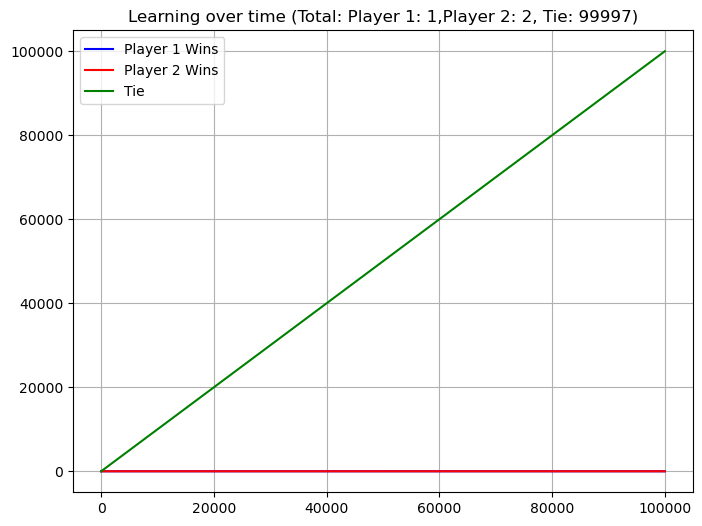

In [87]:
REWARD_FOR_TIE = 0
REWARD_FOR_LOSE = 0
REWARD_FOR_WIN = 0
REWARD_FOR_NOTHING = 0


num_episodes = 100000

p1 = MCAgent(generate_tic_tac_toe_q_a(p=1),epsilon=0.99,discount_factor=0.9)
p2 = MCAgent(generate_tic_tac_toe_q_a(p=2),epsilon=0.99,discount_factor=0.9)

p1.init_q_a()
p2.init_q_a()
wins_p1 = [0]
wins_p2 = [0]
ties = [0]
epsilon_decay_p1 = 0.90
epsilon_decay_p2 = 0.90
for episode in tqdm.tqdm(range(num_episodes)):
    g = TicTacToe()
    winner = 0
    action_p1 = None
    action_p2 = None
    p1.set_epsilon(p1.get_epsilon()*epsilon_decay_p1)
    p2.set_epsilon(p2.get_epsilon()*epsilon_decay_p2)
    while True:
        board_state_p1 = tuple(g.get_board_state())
        action_p1 = p1.get_move(board_state_p1)
        action_p1_state = action_p1
        action_p1 = diff_to_move(board_state_p1,action_p1_state)
        g.do_turn(action_p1)

        if g.get_winner() == -1:
           winner = 0
           ties.append(ties[-1]+1)
           wins_p2.append(wins_p2[-1])
           wins_p1.append(wins_p1[-1])
           break
        if g.get_winner() == 1:
           winner = 1
           ties.append(ties[-1])
           wins_p2.append(wins_p2[-1])
           wins_p1.append(wins_p1[-1]+1)
           break
        if action_p2 != None:
           p2.q_a_update(board_state_p2, action_p2_state, reward=REWARD_FOR_NOTHING, next_state=action_p1_state)
        board_state_p2 = tuple(g.get_board_state())
        action_p2 = p2.get_move(board_state_p2)
        action_p2_state = action_p2
        action_p2 = diff_to_move(board_state_p2,action_p2_state)
        g.do_turn(action_p2)
        if g.get_winner() == 2:
           winner =2
           ties.append(ties[-1])
           wins_p2.append(wins_p2[-1]+1)
           wins_p1.append(wins_p1[-1])
           break

        p1.q_a_update(board_state_p1, action_p1_state, reward=REWARD_FOR_NOTHING, next_state=action_p2_state)
    if winner == 1:
       rewardone = REWARD_FOR_WIN
       rewardtwo = REWARD_FOR_LOSE
    elif winner == 2:
       rewardone = REWARD_FOR_LOSE
       rewardtwo = REWARD_FOR_WIN
    else:
       rewardone = REWARD_FOR_TIE
       rewardtwo = REWARD_FOR_TIE
    p1.q_a_update(board_state_p1, action_p1_state, reward=rewardone, next_state=None)
    p2.q_a_update(board_state_p2, action_p2_state, reward=rewardtwo, next_state=None)

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(list(range(len(wins_p1))), wins_p1, label='Player 1 Wins', color='b')
plt.plot(list(range(len(wins_p1))), wins_p2, label='Player 2 Wins', color='r')
plt.plot(list(range(len(wins_p1))), ties, label='Tie', color='g')
plt.title(f'Learning over time (Total: Player 1: {wins_p1[-1]},Player 2: {wins_p2[-1]}, Tie: {ties[-1]})')
plt.legend()
plt.grid(True)
    

## Q Learning TicTacToe

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16290.36it/s]


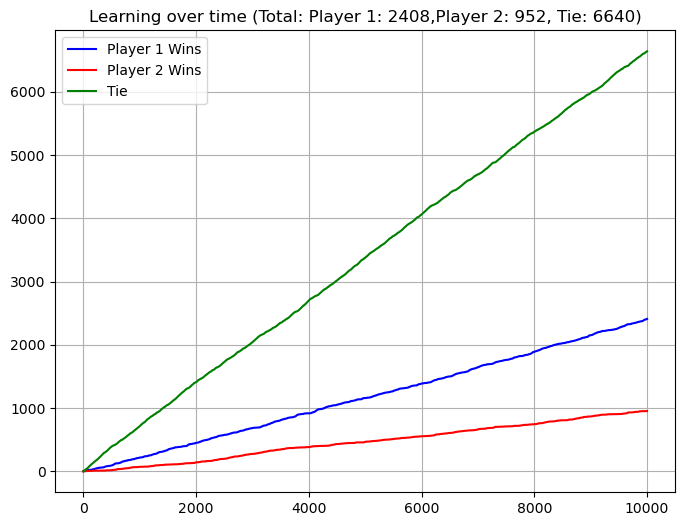

In [86]:
REWARD_FOR_TIE = 0
REWARD_FOR_LOSE = 0
REWARD_FOR_WIN = 0
REWARD_FOR_NOTHING = 0


num_episodes = 10000

p1 = QLearningAgent(generate_tic_tac_toe_q_a(p=1),init_strategy=np.random.normal,epsilon=0.99,learning_rate=0.5,discount_factor=0.95)
p2 = QLearningAgent(generate_tic_tac_toe_q_a(p=2),init_strategy=np.random.normal,epsilon=0.99,learning_rate=0.5,discount_factor=0.95)

p1.init_q_a()
p2.init_q_a()
wins_p1 = [0]
wins_p2 = [0]
ties = [0]
epsilon_decay_p1 = 0.90
epsilon_decay_p2 = 0.90
for episode in tqdm.tqdm(range(num_episodes)):
    g = TicTacToe()
    winner = 0
    action_p1 = None
    action_p2 = None
    p1.set_epsilon(p1.get_epsilon()*epsilon_decay_p1)
    p2.set_epsilon(p2.get_epsilon()*epsilon_decay_p2)
    while True:
        board_state_p1 = tuple(g.get_board_state())
        action_p1 = p1.get_move(board_state_p1)
        action_p1_state = action_p1
        action_p1 = diff_to_move(board_state_p1,action_p1_state)
        g.do_turn(action_p1)

        if g.get_winner() == -1:
           winner = 0
           ties.append(ties[-1]+1)
           wins_p2.append(wins_p2[-1])
           wins_p1.append(wins_p1[-1])
           break
        if g.get_winner() == 1:
           winner = 1
           ties.append(ties[-1])
           wins_p2.append(wins_p2[-1])
           wins_p1.append(wins_p1[-1]+1)
           break
        if action_p2 != None:
           p2.q_a_update(board_state_p2, action_p2_state, reward=REWARD_FOR_NOTHING, next_state=action_p1_state)
        board_state_p2 = tuple(g.get_board_state())
        action_p2 = p2.get_move(board_state_p2)
        action_p2_state = action_p2
        action_p2 = diff_to_move(board_state_p2,action_p2_state)
        g.do_turn(action_p2)
        if g.get_winner() == 2:
           winner =2
           ties.append(ties[-1])
           wins_p2.append(wins_p2[-1]+1)
           wins_p1.append(wins_p1[-1])
           break

        p1.q_a_update(board_state_p1, action_p1_state, reward=REWARD_FOR_NOTHING, next_state=action_p2_state)
    if winner == 1:
       rewardone = REWARD_FOR_WIN
       rewardtwo = REWARD_FOR_LOSE
    elif winner == 2:
       rewardone = REWARD_FOR_LOSE
       rewardtwo = REWARD_FOR_WIN
    else:
       rewardone = REWARD_FOR_TIE
       rewardtwo = REWARD_FOR_TIE
    p1.q_a_update(board_state_p1, action_p1_state, reward=rewardone, next_state=None)
    p2.q_a_update(board_state_p2, action_p2_state, reward=rewardtwo, next_state=None)

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(list(range(len(wins_p1))), wins_p1, label='Player 1 Wins', color='b')
plt.plot(list(range(len(wins_p1))), wins_p2, label='Player 2 Wins', color='r')
plt.plot(list(range(len(wins_p1))), ties, label='Tie', color='g')
plt.title(f'Learning over time (Total: Player 1: {wins_p1[-1]},Player 2: {wins_p2[-1]}, Tie: {ties[-1]})')
plt.legend()
plt.grid(True)
    

## Cartpole Policy Gradient - REINFORCE

In [80]:
import gym
import matplotlib.pyplot as plt
import time
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, clear_output
from torch import nn
import torch
import torch.nn.functional as F

In the policy gradient learning method our neural network receives the state and outputs the probabilities of certain actions given that state - essentially, the neural network is our policy which maps from states to actions.

In [81]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16,2),
            nn.Softmax(),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In policy gradient methods we use a non epsilon greedy method - instead we sample accordingly from our options using a multinomial distribution (1 trial) \[or alternatively we could say that we sample from a categorical distribution\]

In [82]:
ACTION_SPACE = 2
def get_reward(obs,model):
    res= model(torch.Tensor(obs))
    return res

def get_action(obs, model, epsilon):
    action = np.random.choice(np.arange(ACTION_SPACE), p=model(torch.Tensor(obs)).detach().numpy())
    return action

def play_episode(policy_network, env, render=True,epsilon=0.1, max_time=10000):
    observation, _ = env.reset()
    done = False

    for t in range(max_time):
          render_env(env)
          action = get_action(observation, policy_network, epsilon)
          observation, reward, done, _, info = env.step(action)
          if done:
             break
    return t

def run_episode(policy_network, optimizer, env, discount=0.5, epsilon=0.1, max_time=1000, render=False):
    observation, _ = env.reset()
    done = False
    rewards = []
    actions = []
    observations = []

    # Collect data from the episode
    for t in range(max_time):
        action = get_action(observation, policy_network, epsilon)
        observations.append(observation)
        observation, reward, done, _, info = env.step(action)
        rewards.append(reward)
        actions.append(action)

        if done:
            break

    # Calculate the discounted rewards
    discounted_rewards = np.zeros_like(rewards, dtype=np.float32)
    running_add = 0
    for i in reversed(range(0, len(rewards))):
        running_add = rewards[i] + discount * running_add
        discounted_rewards[i] = running_add

    # Convert everything to torch tensors
    optimizer.zero_grad()
    loss = torch.tensor(0.0)

    # Accumulate loss for the episode
    for index, reward in enumerate(discounted_rewards):
        # Calculate the log-probability of the chosen action
        log_prob = torch.log(policy_network(torch.Tensor(observations[index]))[actions[index]])
        # Accumulate the loss (negative reward times log-probability)
        loss += -reward * log_prob

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()

    return t, loss.item()


def render_env(env):
    # Render the environment and get an image
    img = env.render()
    # Convert the image to PIL format
    img = Image.fromarray(img)
    # Clear the previous frame
    clear_output(wait=True)
    # Display the image
    display(img)
    time.sleep(0.05)

In [83]:
N_EPISODES=10000
MAX_EPISODE_STEPS = 1000
RENDER = False
EPSILON_DECAY = 0.95
DISCOUNT_FACTOR = 0.8
EPSILON = 0.99
nru = PolicyNetwork()
optimizer = torch.optim.Adam(nru.parameters(),lr=0.001)
tsum = 0
accloss = 0
average_best_time = 0
best_t = 0
best_params = None
times = []
pbar = tqdm.tqdm(range(N_EPISODES))
for episode in pbar:
    env = gym.make("CartPole-v1",max_episode_steps=MAX_EPISODE_STEPS)
    if episode % 200 == 0:
       EPSILON *=EPSILON_DECAY
    t,loss = run_episode(nru,optimizer,env,discount=DISCOUNT_FACTOR,epsilon=EPSILON,render=RENDER,max_time=MAX_EPISODE_STEPS)
    times.append(t)
    if t > best_t:
       best_t = t
    # time.sleep(1)
    tsum+=t
    average_best_time = tsum/(episode+1)
    accloss+=loss/t
    pbar.set_description(f"Avg loss: {accloss/(episode+1):.2f} Avg Time: {average_best_time:.2f}, Best time: {best_t}, epsilon {EPSILON}")
print(best_t)       

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\conda_envs\ml\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
C:\conda_envs\ml\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Avg loss: 2.86 Avg Time: 117.46, Best time: 999, epsilon 0.24784064884503038:  52%|▌| 5217/10000 [02:33<02:20, 33.97it/

KeyboardInterrupt



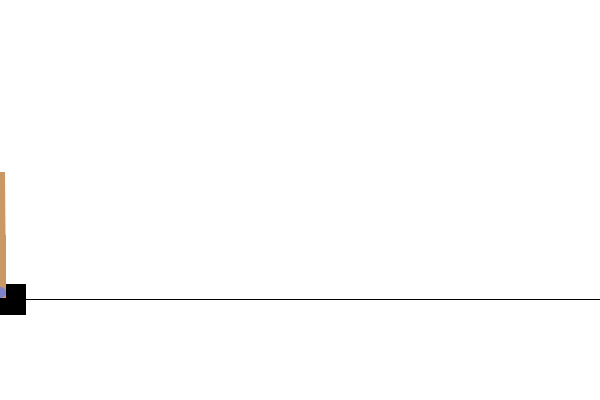

1056

In [14]:
MAX_EPISODE_STEPS = 100000
env = gym.make("CartPole-v1",max_episode_steps=MAX_EPISODE_STEPS, render_mode="rgb_array")
play_episode(nru,env,render=True,epsilon=0.1,max_time=MAX_EPISODE_STEPS)

## Cartpole Policy Gradient - ACTOR CRITIC algorithm

In [6]:
import gym
import matplotlib.pyplot as plt
import time
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, clear_output
from torch import nn
import torch
import torch.nn.functional as F

In [7]:
## Using sigmoid seems to work but ReLU does not as it seems that it results in a very unbalanced prediction
## of state value in the first few epochs while sigmoid seems to be more balanced since it is bounded by (-1,1)
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 16),
            nn.Sigmoid(),
            nn.Linear(16,1),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16,2),
            nn.Softmax(),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

The **advantage function** \( A(s, a) \) in reinforcement learning measures how much better or worse a particular action \( a \) is in a state \( s \) compared to the expected value of that state under the current policy. It is defined as the difference between the action-value function \( Q(s, a) \) and the state-value function \( V(s) \):


$$A(s, a) = Q(s, a) - V(s)$$


This function helps the agent evaluate the **relative quality** of actions, which improves learning by focusing on actions that perform better than expected and discouraging those that perform worse. Using the advantage reduces variance in policy gradient updates, leading to more stable learning.

In **Temporal Difference (TD)** methods, the advantage can be computed using the **TD error**, which incorporates both the immediate reward and the difference between value estimates at consecutive timesteps:


$$A(s_t, a_t) = r_t + \gamma V(s_{t+1}) - V(s_t)$$


The TD error reflects how much better the observed reward and the estimated future value \( V(s_{t+1}) \) are compared to the current value \( V(s_t) \). This helps the agent adjust the policy to reinforce actions that exceed expected outcomes and discourage those that underperform.



In [9]:
ACTION_SPACE = 2
def get_reward(obs,model):
    res= model(torch.Tensor(obs))
    return res

def get_action(obs, model, epsilon):
    action = np.random.choice(np.arange(ACTION_SPACE), p=model(torch.Tensor(obs)).detach().numpy())
    return action

def play_episode(policy_network, env, render=True,epsilon=0.1, max_time=10000):
    observation, _ = env.reset()
    done = False

    for t in range(max_time):
          render_env(env)
          action = get_action(observation, policy_network, epsilon)
          observation, reward, done, _, info = env.step(action)
          if done:
             break
    return t


1. **Actor Loss** (Policy Gradient Loss):
   $${L}_{\text{actor}} = -\mathbb{E} \left[ \delta_t \cdot \log \pi_\theta(a_t | s_t) \right]$$
   Where $$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$ is the **TD error**. The actor loss is weighted by the advantage (TD error) to encourage actions that lead to higher-than-expected rewards.

2. **Critic Loss** (Temporal Difference Loss):
   
   $${L}_{\text{critic}} = \mathbb{E} \left[ \left( r_t + \gamma V(s_{t+1}) - V(s_t) \right)^2 \right]$$
   
   This is the **mean squared TD error**, which trains the critic to minimize the difference between its predicted value and the TD target.


In [10]:
def run_episode(actor_network,optimizer_actor,critic_network, optimizer_critic, env, discount=0.5, epsilon=0.1, max_time=1000, render=False):
    observation, _ = env.reset()
    done = False

    # Collect data from the episode
    for t in range(max_time):
        action = get_action(observation, actor_network, epsilon)
        expected_reward = critic_network(torch.Tensor(observation))
        log_prob = torch.log(actor_network(torch.Tensor(observation))[action])
        observation, reward, done, _, info = env.step(action)


        actual_reward = reward + discount*critic_network(torch.Tensor(observation)).detach()
        advantage = actual_reward - expected_reward.detach()
        loss_actor = -advantage.detach()*log_prob
        optimizer_actor.zero_grad()
        loss_actor.backward()
        optimizer_actor.step()

        loss_critic = (actual_reward - expected_reward)**2
        optimizer_critic.zero_grad()
        loss_critic.backward()
        optimizer_critic.step()
        
        if done:
            break

    return t, loss_actor.item(), loss_critic.item()


def render_env(env):
    # Render the environment and get an image
    img = env.render()
    # Convert the image to PIL format
    img = Image.fromarray(img)
    # Clear the previous frame
    clear_output(wait=True)
    # Display the image
    display(img)
    time.sleep(0.05)

In [12]:
N_EPISODES=10000
MAX_EPISODE_STEPS = 1000
RENDER = False
EPSILON_DECAY = 0.95
DISCOUNT_FACTOR = 0.8
EPSILON = 0.99
policy = PolicyNetwork()
optimizer_policy = torch.optim.Adam(policy.parameters())
value = ValueNetwork()
optimizer_value = torch.optim.Adam(value.parameters())
tsum = 0
accloss = 0
average_best_time = 0
best_t = 0
best_params = None
times = []
pbar = tqdm.tqdm(range(N_EPISODES))
for episode in pbar:
    env = gym.make("CartPole-v1",max_episode_steps=MAX_EPISODE_STEPS)
    t,loss_act,loss_cri = run_episode(policy,optimizer_policy,value,optimizer_value,env,discount=DISCOUNT_FACTOR,max_time=MAX_EPISODE_STEPS)
    times.append(t)
    if t > best_t:
       best_t = t
    tsum+=t
    average_best_time = tsum/(episode+1)
    pbar.set_description(f"Avg loss: actor: {loss_act:.2f} critic: {loss_cri:.2f} Avg Time: {average_best_time}, Best time: {best_t}, epsilon {EPSILON}")
print(best_t)       

Avg loss: actor: 0.00 critic: 0.00 Avg Time: 36.1422, Best time: 146, epsilon 0.99: 100%|█| 10000/10000 [06:38<00:00, 2

146


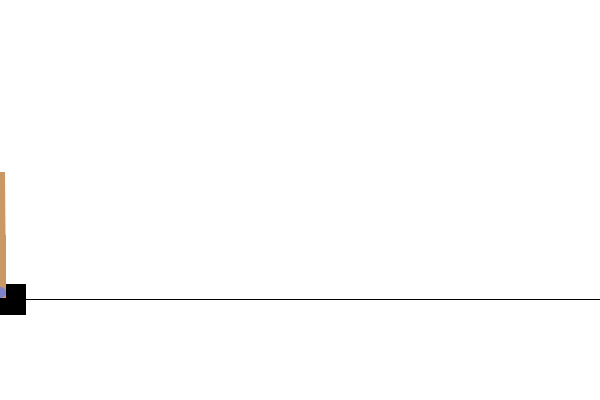

1056

In [14]:
MAX_EPISODE_STEPS = 100000
env = gym.make("CartPole-v1",max_episode_steps=MAX_EPISODE_STEPS, render_mode="rgb_array")
play_episode(nru,env,render=True,epsilon=0.1,max_time=MAX_EPISODE_STEPS)

## PPO

In [1]:
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import tqdm
import time

In [2]:
# Hyperparameters
GAMMA = 0.99  # Discount factor for future rewards
LAMBDA = 0.9
LR = 3e-4  # Learning rate for both policy and value networks
EPSILON_CLIP = 0.2  # Clipping range for PPO objective
K_EPOCHS = 2  # Number of training epochs per update
UPDATE_INTERVAL = 16  # Steps before updating networks
MINI_BATCH = 32

In [3]:
## Using sigmoid seems to work but ReLU does not as it seems that it results in a very unbalanced prediction
## of state value in the first few epochs while sigmoid seems to be more balanced since it is bounded by (-1,1)
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16,1),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 16),
            nn.Sigmoid(),
            nn.Linear(16,2),
            nn.Softmax(),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In [5]:
def get_action(state, policy_net):
    """Selects an action using the policy network and returns the log probability."""
    state_tensor = torch.FloatTensor(state)
    probs = policy_net(state_tensor)  # Compute action probabilities
    dist = Categorical(probs)  # Create a categorical distribution
    action = dist.sample()  # Sample an action
    return action.item(), dist.log_prob(action)  # Return action and log probability


Policy gradient methods update the policy using the **Advantage Function**:
$
\nabla_\theta J(\theta) = \mathbb{E} \left[ \nabla_\theta \log \pi_\theta(a_t | s_t) A_t \right]
$

where $A_t$ tells us how much better or worse an action was compared to expectations.

A simple estimate for $A_t$ is the **Temporal Difference (TD) error**:
$A_t = \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$
However, this **one-step estimate** is very noisy, making learning unstable.
Instead of using a single TD step, we can sum multiple TD residuals:
$A_t = \sum_{l=0}^{T-t} (\gamma)^l \delta_{t+l}$
This **reduces variance**, but introduces **bias** since the critic’s value function may be inaccurate
To improve stability, **Generalized Advantage Estimation (GAE)** blends multiple TD estimates using an **exponential moving average**:
$A_t^{\text{GAE}(\lambda)} = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}$
$A_t = \delta_t + (\gamma \lambda) A_{t+1}$

In [6]:
def compute_advantages(rewards, values, masks):
    """Computes advantages using Generalized Advantage Estimation (GAE)."""
    returns, adv = [], 0
    for step in reversed(range(len(rewards))):
        # Temporal difference (delta) = r + gamma*v(s+1) - v(s)
        value_est = values[step+1] if masks[step] else 0
        delta = rewards[step] + GAMMA * value_est - values[step]
        # Advantage = TD + gamma*advantage
        adv = delta + LAMBDA * GAMMA * adv * masks[step]
        returns.insert(0, adv + values[step])  # Store the return (advantage + value)
    
    advantages = np.array(returns) - np.array(values)  # Compute advantage estimates
    return returns, (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)  # Normalize advantages

In [7]:
from torch.utils.data import TensorDataset, DataLoader

def update(memory, policy_net, value_net, policy_optimizer, value_optimizer):
    """Performs the PPO update step using stored experiences with minibatch updates."""
    
    # Only update if we have enough samples
    if len(memory) < MINI_BATCH:
        return memory

    # Extract stored data from memory
    states, actions, rewards, log_probs_old, values, mask = zip(*memory)
    returns, advantages = compute_advantages(rewards, values, mask)
    
    # Convert lists to tensors
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    log_probs_old = torch.FloatTensor(log_probs_old).detach()
    returns = torch.FloatTensor(returns).detach()
    advantages = torch.FloatTensor(advantages).detach()
    
    # Create a dataset and DataLoader for minibatch processing
    dataset = TensorDataset(states, actions, log_probs_old, returns, advantages)
    loader = DataLoader(dataset, batch_size=MINI_BATCH, shuffle=True)
    
    # For tracking average losses over epochs
    total_policy_loss = 0.0
    total_value_loss = 0.0
    total_batches = 0

    # Perform multiple epochs of updates over the minibatches
    for _ in range(K_EPOCHS):
        for batch in loader:
            batch_states, batch_actions, batch_log_probs_old, batch_returns, batch_advantages = batch

            # Policy update
            probs = policy_net(batch_states)
            dist = Categorical(probs)
            batch_log_probs_new = dist.log_prob(batch_actions)
            ratio = torch.exp(batch_log_probs_new - batch_log_probs_old)
            surr1 = ratio * batch_advantages
            surr2 = torch.clamp(ratio, 1 - EPSILON_CLIP, 1 + EPSILON_CLIP) * batch_advantages
            loss_policy = -torch.min(surr1, surr2).mean()
            
            policy_optimizer.zero_grad()
            loss_policy.backward()
            policy_optimizer.step()
            
            # Value function update
            value_preds = value_net(batch_states).squeeze()
            loss_value = nn.MSELoss()(value_preds, batch_returns)
            
            value_optimizer.zero_grad()
            loss_value.backward()
            value_optimizer.step()
            
            total_policy_loss += loss_policy.item()
            total_value_loss += loss_value.item()
            total_batches += 1

    # Compute average losses over all batches
    avg_policy_loss = total_policy_loss / total_batches if total_batches > 0 else 0
    avg_value_loss = total_value_loss / total_batches if total_batches > 0 else 0

    # Clear memory after the update
    memory = []
    
    return memory, avg_value_loss, avg_policy_loss


In [8]:
policy_net = PolicyNetwork()
value_net = ValueNetwork()
# Optimizers for policy and value networks
policy_optimizer = optim.Adam(policy_net.parameters(),lr=LR)
value_optimizer = optim.Adam(value_net.parameters(),lr=LR)
memory = []
time_sum = 0
total_reward = 0
total_value = 0
total_action = 0
loss_val = 0
loss_pol = 0
episodes = 0
updates = 0
N_EPISODES = 10000
env = gym.make("CartPole-v1")  # Create environment
pbar = tqdm.tqdm(range(N_EPISODES))
for episode in pbar:  # Run training episodes
    state, _ = env.reset()
    done, episode_reward, t = False, 0, 0
    episode_value = 0
    episode_action = 0

    while not done:
        action, log_prob = get_action(state,policy_net)  # Choose action based on policy
        next_state, reward, done, _, _ = env.step(action)  # Take action in environment
        value = value_net(torch.FloatTensor(state)).item()  # Compute state value
        # Store experience tuple in memory
        mask = 0 if done else 1
        memory.append((state, action, reward, log_prob.item(), value, mask))
        state = next_state  # Update state
        episode_reward += reward  # Accumulate episode reward
        t += 1  # Increment time step
        episode_value+=value
        episode_action+=action
    episodes +=1     
    if episodes >= UPDATE_INTERVAL:
        memory, loss_val, loss_pol=update(memory, policy_net, value_net, policy_optimizer, value_optimizer)  # Perform PPO update when enough samples are collected
        updates+=1
        episodes = 0
    total_value+=episode_value/(t) ## average value per this episode
    total_action+=episode_action/(t)
    time_sum+=t
    total_reward+=episode_reward
    pbar.set_description(f"{loss_val:.2f},{loss_pol:.2f},{total_action/(episode+1):.2f}, {total_value/(episode+1):.2f} {time_sum/(episode+1):.2f}")

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\conda_envs\ml\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
C:\conda_envs\ml\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
0.00,0.00,0.48, -0.13 21.87:   0%|                                                  | 10/10000 [00:00<01:44, 96.04it/s]C:\Users\David S\AppData\Local\Temp\ipykernel_33808\2438540640.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\py

## GRPO

In [42]:
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [43]:
# Hyperparameters
GAMMA = 0.99  # Discount factor for future rewards
LR = 3e-4  # Learning rate for both policy and value networks
BETA = 0.1
EPSILON_CLIP = 0.2  # Clipping range for PPO objective
K_EPOCHS = 4  # Number of training epochs per update
G = 16

In [44]:
## Using sigmoid seems to work but ReLU does not as it seems that it results in a very unbalanced prediction
## of state value in the first few epochs while sigmoid seems to be more balanced since it is bounded by (-1,1)
class ValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 16),
            nn.Sigmoid(),
            nn.Linear(16,1),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In [45]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16,2),
            nn.Softmax(),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In [46]:
def get_action(state, policy_net):
    """Selects an action using the policy network and returns the log probability."""
    state_tensor = torch.FloatTensor(state)
    probs = policy_net(state_tensor)  # Compute action probabilities
    dist = Categorical(probs)  # Create a categorical distribution
    action = dist.sample()  # Sample an action
    return action.item(), dist.log_prob(action)  # Return action and log probability


Policy gradient methods update the policy using the **Advantage Function**:
$
\nabla_\theta J(\theta) = \mathbb{E} \left[ \nabla_\theta \log \pi_\theta(a_t | s_t) A_t \right]
$

where $A_t$ tells us how much better or worse an action was compared to expectations.

A simple estimate for $A_t$ is the **Temporal Difference (TD) error**:
$A_t = \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$
However, this **one-step estimate** is very noisy, making learning unstable.
Instead of using a single TD step, we can sum multiple TD residuals:
$A_t = \sum_{l=0}^{T-t} (\gamma)^l \delta_{t+l}$
This **reduces variance**, but introduces **bias** since the critic’s value function may be inaccurate
To improve stability, **Generalized Advantage Estimation (GAE)** blends multiple TD estimates using an **exponential moving average**:
$A_t^{\text{GAE}(\lambda)} = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}$
$A_t = \delta_t + (\gamma \lambda) A_{t+1}$

In [47]:
def compute_advantages(rewards, values, masks):
    """Computes advantages using Generalized Advantage Estimation (GAE)."""
    returns, adv = [], 0
    for step in reversed(range(len(rewards))):
        # Temporal difference (delta) = r + gamma*v(s+1) - v(s)
        value_est = values[step+1] if masks[step] else 0
        delta = rewards[step] + GAMMA * value_est - values[step]
        # Advantage = TD + gamma*advantage
        adv = delta + LAMBDA * GAMMA * adv * masks[step]
        returns.insert(0, adv + values[step])  # Store the return (advantage + value)
    
    advantages = np.array(returns) - np.array(values)  # Compute advantage estimates
    return returns, (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)  # Normalize advantages

In [48]:
def update(group, policy_net, value_net, policy_optimizer, value_optimizer):
    """Performs the GRPO update step using stored experiences."""
    # Flatten all stored sequences
    states, actions, rewards, log_probs_old, values, masks = [], [], [], [], [], []
    
    for o in group:
        s, a, r, log_p, v, m = zip(*o)  # Unzip experience tuple
        states.extend(s)
        actions.extend(a)
        rewards.extend(r)
        log_probs_old.extend(log_p)
        values.extend(v)
        masks.extend(m)

    # Compute advantages and returns
    returns, advantages = compute_advantages(rewards, values,masks)

    # Convert lists to tensors
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions)
    log_probs_old = torch.FloatTensor(log_probs_old).detach()
    returns = torch.FloatTensor(returns)
    advantages = torch.FloatTensor(advantages)

    for _ in range(K_EPOCHS):  # Perform multiple epochs of updates
        
        # Compute new action probabilities
        probs = policy_net(states)
        dist = Categorical(probs)
        log_probs_new = dist.log_prob(actions)

        # Compute probability ratio
        ratio = torch.exp(log_probs_new - log_probs_old)

        # PPO Clipped Objective
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - EPSILON_CLIP, 1 + EPSILON_CLIP) * advantages
        loss_policy = -torch.min(surr1, surr2).mean()
        
        # KL Divergence Regularization
        loss_policy += BETA * torch.nn.functional.kl_div(log_probs_new, log_probs_old,log_target=True, reduction="batchmean")

        # Normalize loss
        loss_policy /= len(group)

        # Compute value loss (MSE with target returns)
        value_preds = value_net(states).squeeze()
        loss_value = nn.MSELoss()(value_preds, returns)

        # Update policy network
        policy_optimizer.zero_grad()
        loss_policy.backward()
        policy_optimizer.step()

        # Update value network
        value_optimizer.zero_grad()
        loss_value.backward()
        value_optimizer.step()
    
    group = []  # Clear experience buffer after update
    return group

In [49]:
policy_net = PolicyNetwork()
value_net = ValueNetwork()
# Optimizers for policy and value networks
policy_optimizer = optim.Adam(policy_net.parameters(), lr=LR)
value_optimizer = optim.Adam(value_net.parameters(), lr=LR)
action_seq = []
group = []
time_sum = 0
episode_reward = 0 
episode_counter = 0

N_EPISODES = 5000
env = gym.make("CartPole-v1")  # Create environment
pbar = tqdm.tqdm(range(N_EPISODES))
for episode in pbar:  # Run training episodes
    init_state, _ = env.reset()
    t= 0
    for o in range(G):
        done, seq_reward = False, 0
        _, _ = env.reset()
        env.env.state = init_state
        state = init_state
        action_seq = []
        while not done:
            action, log_prob = get_action(state,policy_net)  # Choose action based on policy
            next_state, reward, done, _, _ = env.step(action)  # Take action in environment
            # print(next_state,reward,done,t)
            value = value_net(torch.FloatTensor(state)).item()  # Compute state value
            mask = 0 if done else 1
            # Store experience tuple in memory
            action_seq.append((state, action, reward, log_prob.item(), value,mask))
            state = next_state  # Update state
            seq_reward += reward  # Accumulate episode reward
            t += 1  # Increment time step
        group.append(action_seq)
    episode_counter += 1
    episode_reward += seq_reward/G
    t = t/G

    group=update(group, policy_net, value_net,policy_optimizer,value_optimizer)  # Perform PPO update when enough samples are collected
    time_sum+=t
    # time.sleep(3)
    pbar.set_description(f"Avg Time: {time_sum/(episode+1):.2f}, Reward: {episode_reward/(episode+1):.2f}")

Avg Time: 51.99, Reward: 3.31:   5%|██▌                                             | 273/5000 [01:11<20:36,  3.82it/s]


KeyboardInterrupt: 